<a href="https://colab.research.google.com/github/Shiyi-Xia/NLP_ESS_2022/blob/main/Tutorial_Five_(R)_Dropout_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout and Weight Regularization

## Douglas Rice


*This tutorial was originally created by Burt Monroe for his prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll show how to impose some forms of regularization (beyond early stopping) on your network through dropout and regularization penalties on weights. After completing this notebook, you should be familar with:


1. Dropout layers and practice
2. L1 Regularization
3. L2 Regularization


## Set up the Workspace

This takes a few minutes to get all set up. We need to install `reticulate` (which lets R converse with a Python installation), `keras`, and `tensorflow`. When we install `keras`, it installs all of the package dependencies (including `reticulate` and `tensorflow`). Then we check to make sure everything is in working order. Note that, if you wanted to run this on your computer, you would need to have an Anaconda distribution installed. 

## Setup

In [ ]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
library(tensorflow) # reload R tensorflow
library(keras) # reload R keras
tf$constant("Hello Tensorflow") # check that tensorflow is working

Loaded Tensorflow version 2.8.2



tf.Tensor(b'Hello Tensorflow', shape=(), dtype=string)

If everything is working right, after running the above you should see:

```tf.Tensor(b'Hello Tensorflow', shape=(), dtype=string)```



## Get the Data

We'll use the feedforward neural network we just built in Tutorial Four as a stepping stone for learning dropout and regularization. The first step then is to do the same processing to get the data set up in the correct format for our analysis.

In [ ]:
imdb <- keras::dataset_imdb(num_words = 5000)
train_data <- imdb$train$x
train_labels <- imdb$train$y
test_data <- imdb$test$x
test_labels <- imdb$test$y

In [ ]:
word_index <- dataset_imdb_word_index()
reverse_word_index <- names(word_index)
names(reverse_word_index) <- word_index
decoded_review <- sapply(train_data[[1]], 
                         function(index) {
                           word <- if (index >= 3)
reverse_word_index[[as.character(index - 3)]]
                           if (!is.null(word)) word else "?"
                           })
decoded_review

[1] "?"          "this"       "film"       "was"        "just"      
  [6] "brilliant"  "casting"    "location"   "scenery"    "story"     
 [11] "direction"  "everyone's" "really"     "suited"     "the"       
 [16] "part"       "they"       "played"     "and"        "you"       
 [21] "could"      "just"       "imagine"    "being"      "there"     
 [26] "robert"     "?"          "is"         "an"         "amazing"   
 [31] "actor"      "and"        "now"        "the"        "same"      
 [36] "being"      "director"   "?"          "father"     "came"      
 [41] "from"       "the"        "same"       "scottish"   "island"    
 [46] "as"         "myself"     "so"         "i"          "loved"     
 [51] "the"        "fact"       "there"      "was"        "a"         
 [56] "real"       "connection" "with"       "this"       "film"      
 [61] "the"        "witty"      "remarks"    "throughout" "the"       
 [66] "film"       "were"       "great"      "it"         "was"       
 [71] "just"       "brilliant"  "so"         "much"       "that"      
 [76] "i"          "bought"     "the"        "film"       "as"        
 [81] "soon"       "as"         "it"         "was"        "released"  
 [86] "for"        "?"          "and"        "would"      "recommend" 
 [91] "it"         "to"         "everyone"   "to"         "watch"     
 [96] "and"        "the"        "fly"        "?"          "was"       
[101] "amazing"    "really"     "cried"      "at"         "the"       
[106] "end"        "it"         "was"        "so"         "sad"       
[111] "and"        "you"        "know"       "what"       "they"      
[116] "say"        "if"         "you"        "cry"        "at"        
[121] "a"          "film"       "it"         "must"       "have"      
[126] "been"       "good"       "and"        "this"       "definitely"
[131] "was"        "also"       "?"          "to"         "the"       
[136] "two"        "little"     "?"          "that"       "played"    
[141] "the"        "?"          "of"         "norman"     "and"       
[146] "paul"       "they"       "were"       "just"       "brilliant" 
[151] "children"   "are"        "often"      "left"       "out"       
[156] "of"         "the"        "?"          "list"       "i"         
[161] "think"      "because"    "the"        "stars"      "that"      
[166] "play"       "them"       "all"        "grown"      "up"        
[171] "are"        "such"       "a"          "big"        "?"         
[176] "for"        "the"        "whole"      "film"       "but"       
[181] "these"      "children"   "are"        "amazing"    "and"       
[186] "should"     "be"         "?"          "for"        "what"      
[191] "they"       "have"       "done"       "don't"      "you"       
[196] "think"      "the"        "whole"      "story"      "was"       
[201] "so"         "lovely"     "because"    "it"         "was"       
[206] "true"       "and"        "was"        "someone's"  "life"      
[211] "after"      "all"        "that"       "was"        "?"         
[216] "with"       "us"         "all"

In [ ]:
vectorize_sequences <- function(sequences, dimension = 5000) {
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    results[i, sequences[[i]]] <- 1 
  results
}

x_train <- vectorize_sequences(train_data)
x_test <- vectorize_sequences(test_data)

# Also change labels from integer to numeric
y_train <- as.numeric(train_labels)
y_test <- as.numeric(test_labels)

In [ ]:
val_indices <- 1:10000 # not great practice if these are ordered

x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]
y_val <- y_train[val_indices]
partial_y_train <- y_train[-val_indices]

## Dropout

### Update the model architecture with Dropout layers.

Let's start with dropout. Dropout is a form of ensembling, or model averaging. Ensembling of different learners generally improves performance; the more well-estimated models we have, the better we can predict outcomes. 

Burt writes:

>Dropout essentially averages over different *subnetworks* -- that is, the original architecture with connections cut at random. This is an effective and inexpensive way to gain robustness, since the averaging is built into training of a single model. With something like *bagging* -- which estimates models based on *k* bootstrapped samples of the data -- there have to be *k* models trained. In any case, the idea is that this will help the model avoid relying too much on any given pattern and it will then be more general and robust.

>Typical advice is to apply Dropout at a rate of up to 50% on the outputs of hidden layers, and up to 20%, if at all, on the inputs. The intuition on input Dropout is that it adds robustness when there is redundancy among the features. Old school social science translation -- when there's multicollinearity. For, say, image data, there is tremendous redundancy; knocking out random pixels doesn't make it much harder for humans to understand the image. For our problem, this amounts to the question of whether sentiment of a text should still be discernible with 10 or 20% of the words missing at random.

>In general, Dropout is most important in highly parameterized / complicated / expressive models, so we shouldn't expect this to have too much impact on final performance for this simple network. This is just to demonstrate how it works.

In our simple feedforward network, we can add dropout by adding a `Dropout` "layer" between any two node layers. The main parameter is `rate` which defines the probability, in any training timestep, that an input will be set to zero. All remaining weights are scaled up for that time step. 

Let's add three dropout layers. The first is on the input layer; note that we keep the rate to 10% for that layer. After the second and third layers, we add equivalent dropout layers at a rate of 30%. You'll notice below that the addition of dropout layers doesn't influence the number of parameters. 



In [ ]:
model <- keras_model_sequential() %>%
  layer_dropout(rate=.1, input_shape=5000) %>%
  layer_dense(units = 16, activation = "relu", input_shape = 5000) %>%
  layer_dropout(rate=.3) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(rate=.3) %>%
  layer_dense(units = 1, activation = "sigmoid")

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dropout_2 (Dropout)                (None, 5000)                    0           
 dense_2 (Dense)                    (None, 16)                      80016       
 dropout_1 (Dropout)                (None, 16)                      0           
 dense_1 (Dense)                    (None, 16)                      272         
 dropout (Dropout)                  (None, 16)                      0           
 dense (Dense)                      (None, 1)                       17          
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
________________________________________________________________________________


## Compile and Evaluate

With the model architecture specified, we turn to compiling it. Recall that we need to specify our optimization function, our loss function, and metrics for evaluation. We'll stick with what we did before.

In [ ]:
model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 50,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

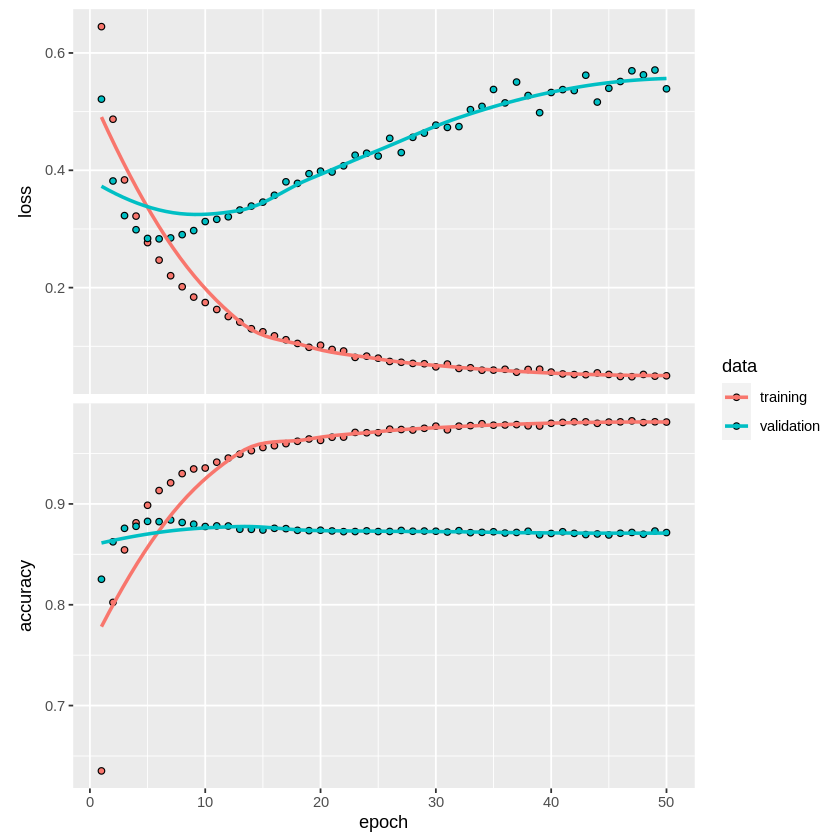

In [ ]:
plot(history)

Recall that in our earlier model, it looked like we should stop around 4 or 5 epochs to avoid overfitting. In the model with dropout, it looks liked we should stop around 5 or 6 epochs, so not a big difference. Let's do it again but stop early.

In [ ]:
model <- keras_model_sequential() %>%
  layer_dropout(rate=.1, input_shape=5000) %>%
  layer_dense(units = 16, activation = "relu", input_shape = 5000) %>%
  layer_dropout(rate=.3) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(rate=.3) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 6,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

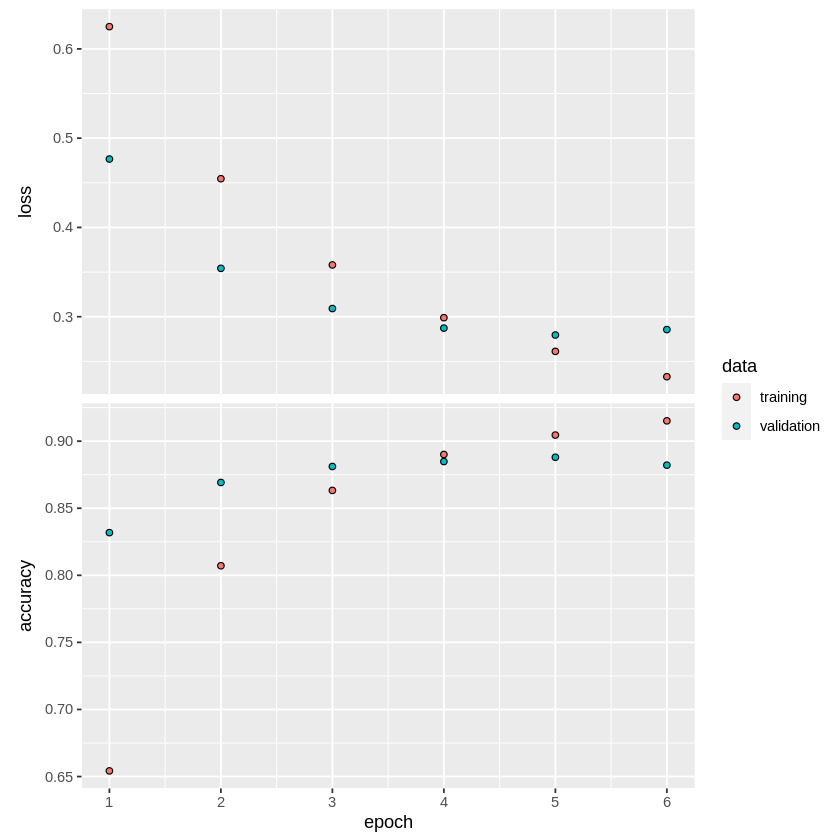

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(x_test, y_test)
results

loss  accuracy 
0.2946321 0.8767200

88% accuracy (again, give or take with a stochastic element here). In general, it looks like the model with dropout is doing a tiny bit better than the baseline.

### Add a LOT of dropout

For illustration purposes (only), let's way overdo it. We'll have a dropout rate of 50% for the input layer, then a dropout rate of 80% for the following two layers. With all that dropout, we'll pump the epochs back up.

In [ ]:
model <- keras_model_sequential() %>%
  layer_dropout(rate=.5, input_shape=5000) %>%
  layer_dense(units = 16, activation = "relu", input_shape = 5000) %>%
  layer_dropout(rate=.8) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(rate=.8) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

In [ ]:
history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 50,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

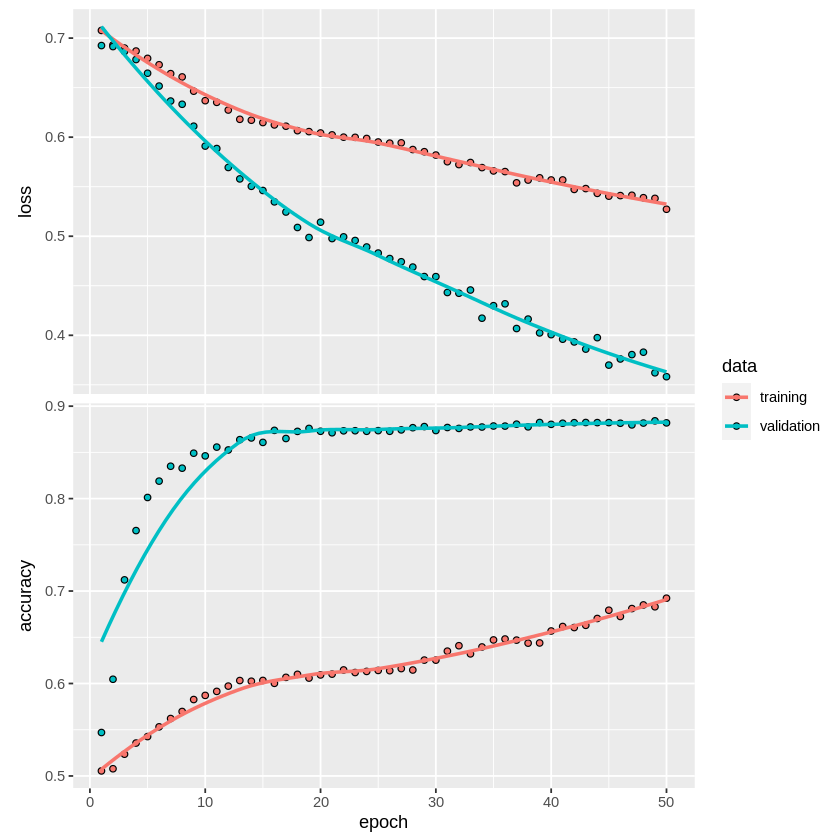

In [ ]:
plot(history)

That's the first time we've seen that. The training accuracy never catches up to the validation accuracy (and likewise for loss). In fact, the training accuracy never gets above about 80% because it's missing most of its connections on each run. 

In [ ]:
results <- model %>% evaluate(x_test, y_test)
results

loss  accuracy 
0.3670703 0.8798000

This model is a bit worse than the baseline model with no dropout, and likewise worse than the model with less aggressive dropout. 

## Regularization

We can also update the model by imposing *regularization*, or imposing a penalty on large weights (in other contexts, you can think about this as imposing a penalty on really large coefficients). The value of imposing that regularization is to avoid overfitting; we'll limit the influence of particular weights. 

There are two forms of regularization to consider: L1 and L2. The L1 regularization imposes a penalty based on the absolute value of the weight, and in doing so shrinks the weights of less important features towards zero. In doing so, it acts as a *feature selection* tool. The L2 regularization  imposes a penalty based on the squared value of the weight. In doing so, it has a "shrinkage" effect, making weights/coefficients smaller. 

## Adding a Regularization Layer

The process within Keras for adding layers is straightforward. We simply add `kernel_regularizer` to a layer. In doing so, we apply that regularizer to the **incoming** weights. You can apply an L1 penalty, an L2 penalty, or both.

### L1-penalty on upper layers

Let's start by applying an L1-penalty on the upper (i.e., final) layers of the network. All of the specifications will follow the model that we've been developing to this point, but with the regularization now added on these incoming weights at the upper layers of our network. The only thing we need to specify beyond our prior steps is the L1 regularization factor; the basic thing to know is that as you increase this factor, the greater the penalty. The default value is 0.01. 

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu", input_shape = c(5000)) %>%
  layer_dense(units = 16, activation = "relu", kernel_regularizer = regularizer_l1(0.01)) %>%
  layer_dense(units = 1, activation = "sigmoid", kernel_regularizer = regularizer_l1(0.01))

summary(model)

model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 50,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_11 (Dense)                   (None, 16)                      80016       
 dense_10 (Dense)                   (None, 16)                      272         
 dense_9 (Dense)                    (None, 1)                       17          
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
________________________________________________________________________________


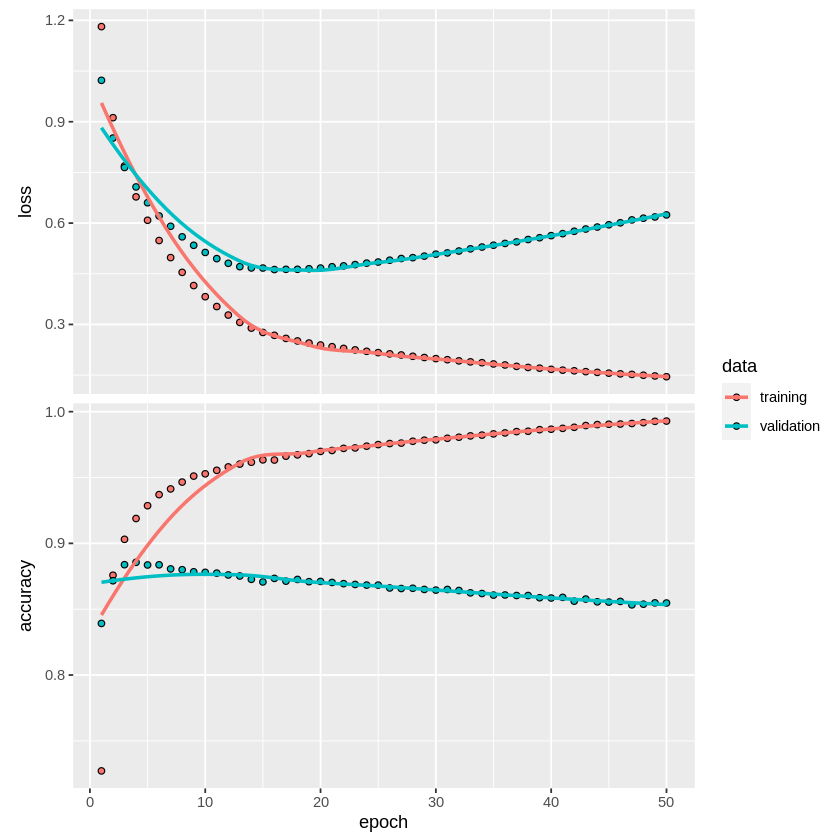

In [ ]:
plot(history)

These are interesting. Note that, within the *validation* set, we are actually moving in the *wrong* direction after the 13th (loss) or 4th (accuracy) epoch. That divergence between metrics is something that we haven't really encountered before. If we wanted to avoid overfitting, which should we rely on? Generally speaking, we should rely on loss when the two diverge. As intuition, the loss function has more granularity (i.e., it tells us how close we are in making our cutpoints) whereas accuracy is just concerned about right/wrong. 

Let's estimate with the earlier stopping point and see how we're doing. We'll stop after 13 epochs given the loss results above.


Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_14 (Dense)                   (None, 16)                      80016       
 dense_13 (Dense)                   (None, 16)                      272         
 dense_12 (Dense)                   (None, 1)                       17          
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
________________________________________________________________________________


loss  accuracy 
0.4932919 0.8692800

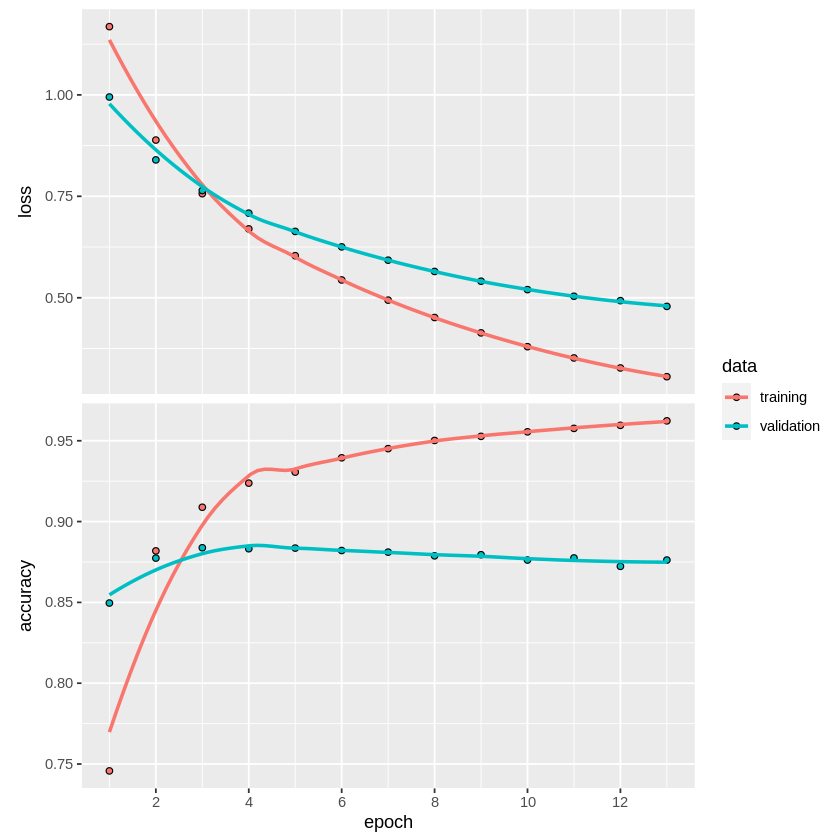

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu", input_shape = c(5000)) %>%
  layer_dense(units = 16, activation = "relu", kernel_regularizer = regularizer_l1(0.01)) %>%
  layer_dense(units = 1, activation = "sigmoid", kernel_regularizer = regularizer_l1(0.01))

summary(model)

model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 13,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

plot(history)

results <- model %>% evaluate(x_test, y_test)
results

And again about 87% accuracy (although it looks like we could have gotten higher with the earlier stopping).

### Something more like the LASSO -- L1-penalty on the first layer.

We can also apply L1 regularization on the inputs to the first hidden layer. For folks that are familiar, this is closer to the logic of LASSO regressions, where we are pushing closer to a feature selection model. The model is pushing the weights at the first stage (i.e., word to hidden node) to be zero, meaning that word would not influence the output. 

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_17 (Dense)                   (None, 16)                      80016       
 dense_16 (Dense)                   (None, 16)                      272         
 dense_15 (Dense)                   (None, 1)                       17          
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
________________________________________________________________________________


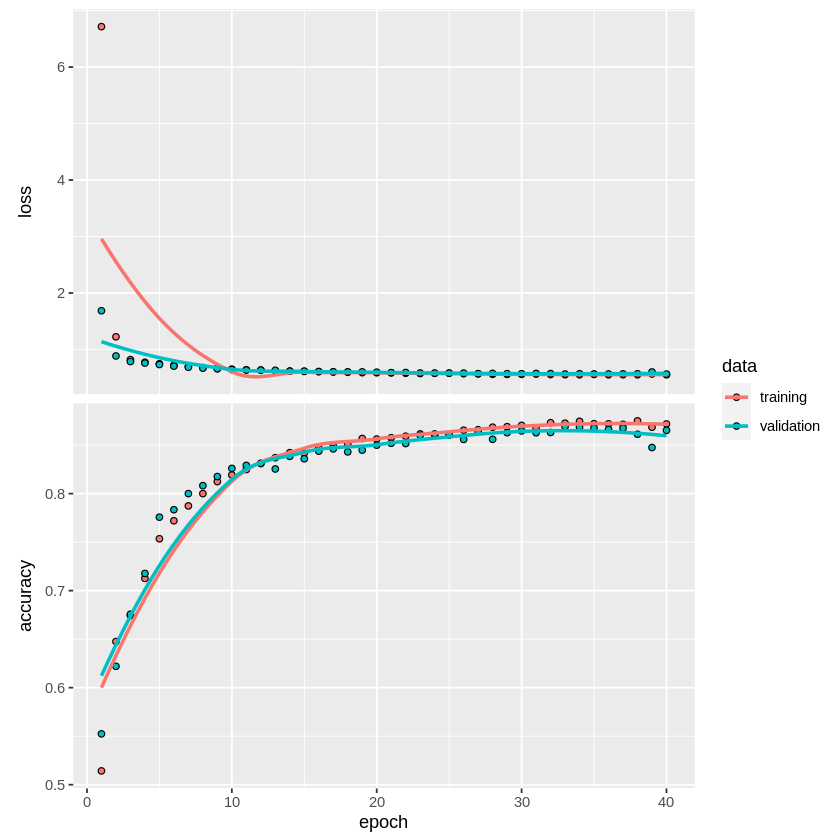

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu", input_shape = c(5000), kernel_regularizer = regularizer_l1(0.01)) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")

summary(model)

model %>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 40,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose = 2
)

plot(history)

Look at that! It definitely dampens the overfitting. The match of the training/validation sets in terms of accuracy seems promising. Let's evaluate with our held-out set.

In [ ]:
results <- model %>% evaluate(x_test, y_test)
results

loss  accuracy 
0.5698856 0.8609600

Ah, 86%. We've definitely limited our overfitting, but we're also not doing quite as well. Some more fine-tuning (and maybe some longer training sessions) is probably in order.

## Inside the Weights

We've been estimating these models and looking at the outcomes, but it's worthwhile to return to what the models are doing now relative to the baseline: adjusting the weights. Let's take a look at the weights.

In [ ]:
model.weights.approx <- (get_weights(model)[[1]] %*% get_weights(model)[[3]]  %*% get_weights(model)[[5]])[,1]
top_words <- reverse_word_index[as.character(1:5000)]
names(model.weights.approx) <- c("<PAD>","<START>","<UNK>",top_words[1:4997])

as.data.frame(sort(model.weights.approx, dec=T)[1:20])

as.data.frame(sort(model.weights.approx, dec=F)[1:20])

,"sort(model.weights.approx, dec = T)[1:20]"
,<dbl>
7,1.1865009
excellent,1.0494352
8,1.0434415
perfect,0.8522754
great,0.7797896
amazing,0.7578472
incredible,0.7214987
wonderful,0.7142212
rare,0.6832815


,"sort(model.weights.approx, dec = F)[1:20]"
,<dbl>
worst,-1.4489945
waste,-1.3757022
awful,-1.2760547
fails,-1.0857312
poorly,-1.0052846
boring,-0.9649532
dull,-0.9223059
mess,-0.8997298
disappointing,-0.8906609


Well, the numbers are different, but the words are basically the same as we saw in the past. We're finding the same important features in this set as we did in the models without regularization. As was mentioned earlier, it's possible that regularization just isn't that useful with a relatively uncomplicated model (as here). 

That said, one way you *can* see the influence of regularization is by thinking about what those changes in the magnitude of the weights represent. Not only are these weights greater, regularization also means lots of weights have been pushed towards zero. Let's look at the distribution of the terms according to their weights (first plot) and the overall distribution of weights (second plot) to see exactly what I mean.

In [ ]:
options(jupyter.plot_scale=1)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“2 x values <= 0 omitted from logarithmic plot”


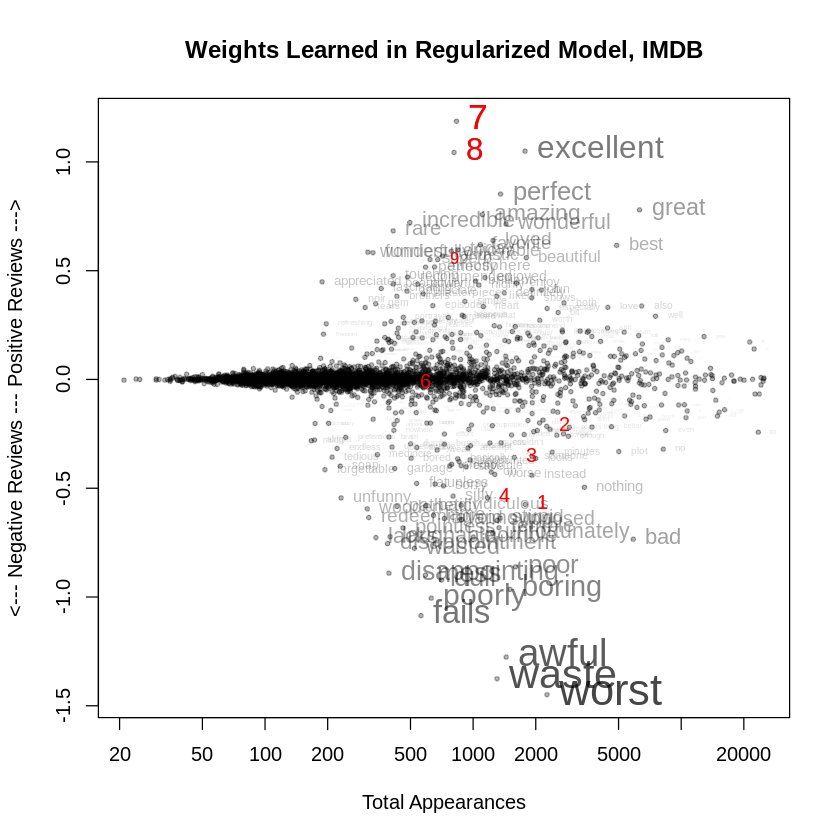

In [ ]:
colnames(x_train) <- names(model.weights.approx)
# Plot weights
plot(colSums(x_train),model.weights.approx, pch=19, col=rgb(0,0,0,.3), cex=.5, log="x", main="Weights Learned in Regularized Model, IMDB", ylab="<--- Negative Reviews --- Positive Reviews --->", xlab="Total Appearances")
text(colSums(x_train),model.weights.approx, names(model.weights.approx),pos=4,cex=1.5*abs(model.weights.approx), col=rgb(0,0,0,.5*abs(model.weights.approx)))
text(colSums(x_train[,c("1","2","3","4","5","6","7","8","9")]),model.weights.approx[c("1","2","3","4","5","6","7","8","9")], names(model.weights.approx[c("1","2","3","4","5","6","7","8","9")]),pos=4,cex=1.5*model.weights.approx[c("1","2","3","4","5","6","7","8","9")], col=rgb(1,0,0,1))

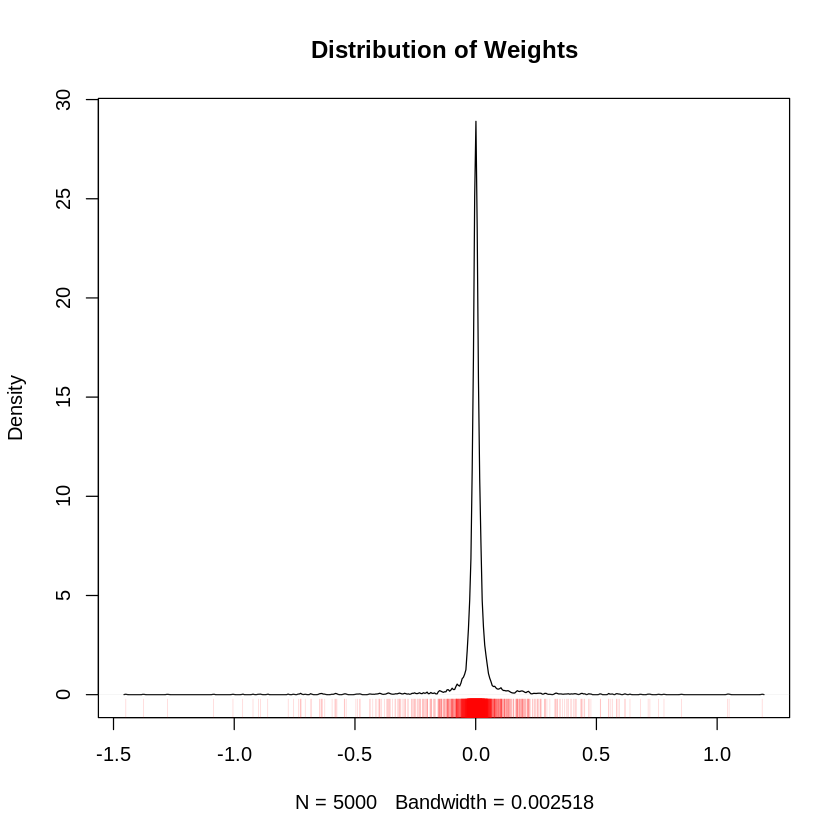

In [ ]:
plot(density(model.weights.approx), main = "Distribution of Weights")
rug(model.weights.approx, col=rgb(1,0,0,.2))